# Predict Stop Signal Response Time  (SSRT)

This notebook uses stop signal task fMRI data derived contrasts from the ABCD study to 
predict stop signal response time (SSRT). This is an example of a regression type machine learning,
and additionally includes an extra example of how to plot ROIs feature importance on brain surfaces from nilearn. 

## Loading Data

We will be loading data from is essentially a big csv file with all the different columns, some slightly processed, from the ABCD DEAP rds (saved r dataframe). The benefit of this approach is that while a little slow, we can just load any column of interest easily as a dataframe.

In [1]:
import BPt as bp
import pandas as pd

In [2]:
def load_from_rds(names, eventname='baseline_year_1_arm_1'):
    
    data = pd.read_csv('data/nda_rds_201.csv',
                       usecols=['src_subject_id', 'eventname'] + names,
                       na_values=['777', 999, '999', 777])
    
    data = data.loc[data[data['eventname'] == eventname].index]
    data = data.set_index('src_subject_id')
    data = data.drop('eventname', axis=1)
    
    return data

In [3]:
# This way we can look at all column available
all_cols = list(pd.read_csv('data/nda_rds_201.csv', nrows=0))
all_cols[:10]

['subjectid',
 'src_subject_id',
 'eventname',
 'anthro_1_height_in',
 'anthro_2_height_in',
 'anthro_3_height_in',
 'anthro_height_calc',
 'anthro_weight_cast',
 'anthro_weight_a_location',
 'anthro_weight1_lb']

In [4]:
# Use python list comprehensions to get lists of the column names of interest
contrasts = ['tfmri_sst_all_correct.go.vs.fixation_beta_',
             'tfmri_sst_all_correct.stop.vs.correct.go_beta_',
             'tfmri_sst_all_incorrect.stop.vs.correct.go_beta_']

                 
parcs = ['.destrieux', '_subcort.aseg']

data_cols = [col for col in all_cols
             if any([ct for ct in contrasts if ct in col])
             and any([p for p in parcs if p in col])] + ['sex']
target_col = ['tfmri_sst_all_beh_total_mean.rt']

In [5]:
# Load the actual data from the saved csv
df = load_from_rds(data_cols + target_col)

In [6]:
# Cast from a dataframe to BPt Dataset class
data = bp.Dataset(df)
    
# Obsificate subject ID for public example
data.index = list(range(len(data)))

# Set optional verbosity of
data.verbose = 1

In [7]:
data = data.drop_cols(exclusions=['.ventricle', '_csf', '.white.matter'], scope='_subcort.aseg')

Dropped 27 Columns


Data in BPt can have one of three roles, these are 'data' by default, 'target' for variable to predict, and 'non input' for variables which we don't use directly as input features. We set 'sex' as non input in this example.

In [8]:
data = data.set_role('sex', 'non input')
data = data.set_role(target_col, 'target')
data

Dropped 6 Rows


,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.occipital.inf.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.occipital.inf.rh,...,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_inf.lat.vent.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_inf.lat.vent.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_pallidum.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_pallidum.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.rh
0,0.168032,0.153849,0.045860,0.023883,0.081824,0.015926,0.142664,0.035705,-0.169860,-0.128688,...,-0.036716,0.052883,-0.006478,-0.025535,0.030901,-0.022286,0.091828,0.158497,0.101536,0.234851
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.052402,0.101880,0.111399,0.124650,0.113433,0.125727,0.579317,0.611870,0.224255,0.343618,...,-0.070160,0.097003,0.026871,0.191424,0.026224,0.036808,0.091165,0.044027,0.071074,0.042021
3,-0.092771,0.007574,0.182024,0.115439,0.096595,0.096851,0.289666,-0.129820,0.188761,0.178344,...,0.342260,-0.114128,-0.097753,-0.082544,-0.145369,-0.187083,-0.159170,-0.113892,-0.242210,-0.175904
4,-0.144128,-0.074626,-0.001618,0.142387,0.241128,0.227172,-0.141231,0.475396,0.573906,1.363352,...,-0.183606,-0.118741,-0.055955,0.046954,-0.018277,0.092319,0.053306,0.060963,0.116601,-0.102220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,-0.103273,-0.060990,0.008791,0.186439,0.059300,0.047829,0.130752,0.184572,0.100078,0.049040,...,0.010403,-0.149049,-0.024082,0.016314,-0.045987,-0.090321,0.066490,0.055350,0.022404,0.095318
11871,-0.060443,-0.123368,-0.024308,-0.122978,-0.143336,-0.098973,0.327409,0.055603,-0.203490,-0.129804,...,-0.168353,0.058014,-0.080418,0.080907,-0.095893,-0.069077,0.009947,0.034421,0.007450,-0.075879
11872,0.012809,0.010143,0.012343,-0.006711,-0.072679,-0.084823,-0.203417,-0.210167,-0.270940,-0.143613,...,-0.044618,0.116003,0.264322,0.134182,0.323175,0.366650,0.254944,0.388157,0.411429,0.312342
11873,0.164396,0.202513,0.376726,0.257396,0.371823,0.123384,0.507308,0.788963,0.260868,0.246349,...,0.538963,-0.930948,-0.225716,-0.347940,-0.305339,-0.380956,-0.123154,-0.251212,-0.270063,-0.336481


In [9]:
# Cast sex as a binary variable
data.to_binary('sex', inplace=True)
data['sex']

0        0
1        0
2        1
3        1
4        1
        ..
11870    1
11871    0
11872    0
11873    0
11874    0
Name: sex, Length: 11869, dtype: category
Categories (2, int64): [0, 1]

In [10]:
# Let's drop all missing data
data.dropna(inplace=True)
data.shape

(8847, 509)

We can filter outliers from the data columns but also the target columns, essentially every 'float' type column.

In [11]:
data = data.filter_outliers_by_std(n_std=10, scope='float')

Dropped 327 Rows


We can also plot individual variables

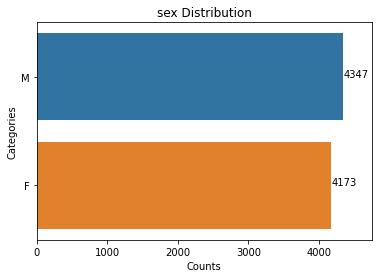

In [12]:
data.plot(scope='sex', subjects='all', decode_values=True, count=True)

## Define a train-test split

What if we wanted to define a train-test split? But also do it according to some criteria, say stratifying by sex?

In [13]:
# First define a CVStrategy that says stratify by sex
sex_strat = bp.CVStrategy(stratify='sex')
sex_strat

CVStrategy(stratify='sex')

In [14]:
# Apply the test_split
data = data.set_test_split(size=.2, cv_strategy=sex_strat, random_state=2)
data

Performing test split on: 8520 subjects.
random_state: 2
Test split size: 0.2

Performed train/test split
Train size: 6816
Test size:  1704


,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.occipital.inf.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.occipital.inf.rh,...,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_inf.lat.vent.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_inf.lat.vent.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_pallidum.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_pallidum.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.rh
0,0.168032,0.153849,0.045860,0.023883,0.081824,0.015926,0.142664,0.035705,-0.169860,-0.128688,...,-0.036716,0.052883,-0.006478,-0.025535,0.030901,-0.022286,0.091828,0.158497,0.101536,0.234851
2,0.052402,0.101880,0.111399,0.124650,0.113433,0.125727,0.579317,0.611870,0.224255,0.343618,...,-0.070160,0.097003,0.026871,0.191424,0.026224,0.036808,0.091165,0.044027,0.071074,0.042021
3,-0.092771,0.007574,0.182024,0.115439,0.096595,0.096851,0.289666,-0.129820,0.188761,0.178344,...,0.342260,-0.114128,-0.097753,-0.082544,-0.145369,-0.187083,-0.159170,-0.113892,-0.242210,-0.175904
4,-0.144128,-0.074626,-0.001618,0.142387,0.241128,0.227172,-0.141231,0.475396,0.573906,1.363352,...,-0.183606,-0.118741,-0.055955,0.046954,-0.018277,0.092319,0.053306,0.060963,0.116601,-0.102220
5,-0.243239,-0.152293,-0.078217,-0.061314,-0.044547,-0.096233,0.298622,-0.083202,-0.082675,-0.071584,...,0.015237,0.129581,0.222719,0.122448,0.244788,0.159455,0.342455,0.230097,0.133497,0.230591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,-0.103273,-0.060990,0.008791,0.186439,0.059300,0.047829,0.130752,0.184572,0.100078,0.049040,...,0.010403,-0.149049,-0.024082,0.016314,-0.045987,-0.090321,0.066490,0.055350,0.022404,0.095318
11871,-0.060443,-0.123368,-0.024308,-0.122978,-0.143336,-0.098973,0.327409,0.055603,-0.203490,-0.129804,...,-0.168353,0.058014,-0.080418,0.080907,-0.095893,-0.069077,0.009947,0.034421,0.007450,-0.075879
11872,0.012809,0.010143,0.012343,-0.006711,-0.072679,-0.084823,-0.203417,-0.210167,-0.270940,-0.143613,...,-0.044618,0.116003,0.264322,0.134182,0.323175,0.366650,0.254944,0.388157,0.411429,0.312342
11873,0.164396,0.202513,0.376726,0.257396,0.371823,0.123384,0.507308,0.788963,0.260868,0.246349,...,0.538963,-0.930948,-0.225716,-0.347940,-0.305339,-0.380956,-0.123154,-0.251212,-0.270063,-0.336481


## Define an ML Pipeline

In [15]:
# Let's define a Pipeline, first by creating a series of based objects

# Standard Scaling
scaler = bp.Scaler('standard', scope='float')

# Ridge Regression model
ridge = bp.Model('ridge', params=1)

# Parameter search strategy,
# using different evolution and a custom nested
# CV strategy.
search = bp.ParamSearch(search_type='DE',
                        n_iter=60,
                        cv=bp.CV(splits=.5,
                                 n_repeats=5))

pipe = bp.Pipeline([scaler, ridge], param_search=search)
pipe

Pipeline(param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy(), n_repeats=5,
                                        splits=0.5),
                                  n_iter=60, search_type='DE'),
         steps=[Scaler(obj='standard'), Model(obj='ridge', params=1)])

## Evaluating an ML Pipeline

In [16]:
# We can store some commonly used parameters in this
# ProblemSpec object. Though note, problem_type and scorer can both be automatically
# detected and set.
spec = bp.ProblemSpec(problem_type='regression',
                      scorer=['r2', 'explained_variance', 'neg_mean_squared_error'],
                      random_state=51,
                      n_jobs=8)

In [17]:
results = bp.evaluate(pipeline=pipe,
                      dataset=data,
                      problem_spec=spec,
                      subjects='train', # This line is important! It says we only want to evaluate on the train set
                      cv=3)
results

Predicting target = tfmri_sst_all_beh_total_mean.rt
Using problem_type = regression
Using scope = all (defining a total of 507 features).
Evaluating 6816 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (4544, 507)
Validation Set: (2272, 507)
Fit fold in 22.2 seconds.
r2: 0.0763
explained_variance: 0.0764
neg_mean_squared_error: -6106.31

Training Set: (4544, 507)
Validation Set: (2272, 507)
Fit fold in 20.3 seconds.
r2: 0.0685
explained_variance: 0.0685
neg_mean_squared_error: -5981.29

Training Set: (4544, 507)
Validation Set: (2272, 507)
Fit fold in 24.9 seconds.
r2: 0.0950
explained_variance: 0.0952
neg_mean_squared_error: -5937.91



EvalResults
------------
r2: 0.0799 ± 0.0111
explained_variance: 0.0800 ± 0.0112
neg_mean_squared_error: -6008.50 ± 71.39

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: tfmri_sst_all_beh_total_mean.rt
problem_type: regression
scope: all
subjects: train
random_state: 51
n_jobs: 8


In [18]:
# Helper to get mean feature importances, in this case beta weights
results.get_fis(mean=True)

tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.lh         0.094617
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.rh        -0.039810
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh     0.589316
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.rh    -0.660932
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.lh   -0.876352
                                                                                         ...   
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.rh                3.166867
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.lh       -0.867134
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.rh       -1.640495
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.lh             -1.039642
tfmri_sst_all_incorrect.stop.vs.correct.

Since a train-test split is being employed, there would at this stage likely be some sort of exploration of different pipelines. Or for example exploration with a limited feature set, i.e., what if we only want to try one of the contrasts? We can just specify a scope.

In [19]:
results = bp.evaluate(pipeline=pipe,
                      dataset=data,
                      problem_spec=spec,
                      scope='tfmri_sst_all_incorrect.stop.vs.correct.go_beta_',
                      subjects='train',
                      cv=3)
results

Predicting target = tfmri_sst_all_beh_total_mean.rt
Using problem_type = regression
Using scope = tfmri_sst_all_incorrect.stop.vs.correct.go_beta_ (defining a total of 169 features).
Evaluating 6816 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (4544, 169)
Validation Set: (2272, 169)
Fit fold in 13.6 seconds.
r2: 0.0554
explained_variance: 0.0554
neg_mean_squared_error: -6244.73

Training Set: (4544, 169)
Validation Set: (2272, 169)
Fit fold in 13.2 seconds.
r2: 0.0506
explained_variance: 0.0506
neg_mean_squared_error: -6095.98

Training Set: (4544, 169)
Validation Set: (2272, 169)
Fit fold in 14.0 seconds.
r2: 0.0506
explained_variance: 0.0507
neg_mean_squared_error: -6228.68



EvalResults
------------
r2: 0.0522 ± 0.0023
explained_variance: 0.0522 ± 0.0023
neg_mean_squared_error: -6189.79 ± 66.66

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: tfmri_sst_all_beh_total_mean.rt
problem_type: regression
scope: tfmri_sst_all_incorrect.stop.vs.correct.go_beta_
subjects: train
random_state: 51
n_jobs: 8


Or along the same lines, we could also specify a sub-set of subects to evaluate by. We can use two custom input objects for this.

In [20]:
sex_m = bp.ValueSubset('sex', 'M', decode_values=True)
sex_f = bp.ValueSubset('sex', 'F', decode_values=True)

sex_m_train = bp.Intersection(['train', sex_m])
sex_f_train = bp.Intersection(['train', sex_f])

# Look at what this refers to explicitly
len(data.get_subjects(sex_m_train)), len(data.get_subjects(sex_f_train))

(3478, 3338)

In [21]:
results = bp.evaluate(pipeline=pipe,
                      dataset=data,
                      problem_spec=spec,
                      scope='tfmri_sst_all_incorrect.stop.vs.correct.go_beta_',
                      subjects=sex_m_train,
                      cv=3)
results

Predicting target = tfmri_sst_all_beh_total_mean.rt
Using problem_type = regression
Using scope = tfmri_sst_all_incorrect.stop.vs.correct.go_beta_ (defining a total of 169 features).
Evaluating 3478 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (2318, 169)
Validation Set: (1160, 169)
Fit fold in 8.8 seconds.
r2: 0.0365
explained_variance: 0.0387
neg_mean_squared_error: -6984.27

Training Set: (2319, 169)
Validation Set: (1159, 169)
Fit fold in 8.3 seconds.
r2: 0.0468
explained_variance: 0.0470
neg_mean_squared_error: -5848.04

Training Set: (2319, 169)
Validation Set: (1159, 169)
Fit fold in 7.8 seconds.
r2: 0.0242
explained_variance: 0.0272
neg_mean_squared_error: -6266.21



EvalResults
------------
r2: 0.0359 ± 0.0093
explained_variance: 0.0376 ± 0.0081
neg_mean_squared_error: -6366.17 ± 469.22

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: tfmri_sst_all_beh_total_mean.rt
problem_type: regression
scope: tfmri_sst_all_incorrect.stop.vs.correct.go_beta_
subjects: Intersection(['train', ValueSubset(name=sex, values=M, decode_values=True)])
random_state: 51
n_jobs: 8


## Comparing different pipelines

What if we wanted to explicitly compare results by sex? We have another special objects for that called Compare. Compare will run a seperate evaluate for each Option, where an Option represents a choice.

In [22]:
compare_subjects = bp.Compare([bp.Option(sex_m_train, name='M'),
                               bp.Option(sex_f_train, name='F')])

results = bp.evaluate(pipeline=pipe,
                      dataset=data,
                      problem_spec=spec,
                      scope='tfmri_sst_all_incorrect.stop.vs.correct.go_beta_',
                      subjects=compare_subjects,
                      cv=3)

# The returned CompareDict has a special summary method
results.summary()

Running Compare: Options(subjects=M)
Predicting target = tfmri_sst_all_beh_total_mean.rt
Using problem_type = regression
Using scope = tfmri_sst_all_incorrect.stop.vs.correct.go_beta_ (defining a total of 169 features).
Evaluating 3478 total data points.


Compare:   0%|          | 0/2 [00:00<?, ?it/s]

Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (2318, 169)
Validation Set: (1160, 169)
Fit fold in 7.7 seconds.
r2: 0.0365
explained_variance: 0.0387
neg_mean_squared_error: -6984.27

Training Set: (2319, 169)
Validation Set: (1159, 169)
Fit fold in 7.4 seconds.
r2: 0.0468
explained_variance: 0.0470
neg_mean_squared_error: -5848.04

Training Set: (2319, 169)
Validation Set: (1159, 169)
Fit fold in 8.1 seconds.
r2: 0.0183
explained_variance: 0.0209
neg_mean_squared_error: -6304.03

Running Compare: Options(subjects=F)
Predicting target = tfmri_sst_all_beh_total_mean.rt
Using problem_type = regression
Using scope = tfmri_sst_all_incorrect.stop.vs.correct.go_beta_ (defining a total of 169 features).
Evaluating 3338 total data points.

Training Set: (2225, 169)
Validation Set: (1113, 169)
Fit fold in 7.0 seconds.
r2: 0.0488
explained_variance: 0.0491
neg_mean_squared_error: -6735.45

Training Set: (2225, 169)
Validation Set: (1113, 169)
Fit fold in 6.8 seconds.
r2: 0.0753
explained_variance: 0.0753
neg_mean_squared_error

,mean_scores_r2,mean_scores_explained_variance,mean_scores_neg_mean_squared_error,std_scores_r2,std_scores_explained_variance,std_scores_neg_mean_squared_error,n_subjects
subjects,,,,,,,
M,0.033903,0.035526,-6378.781140,0.011796,0.010885,466.864793,3478
F,0.056878,0.057190,-6081.657498,0.013060,0.012843,487.742259,3338


## Using the Test Set

While in practice you might want to explore more options with the train set first, let's just move on to showing how we could test a final pipeline on the testing set, while training on the full train set.

In [23]:
results = bp.evaluate(pipeline=pipe,
                      dataset=data,
                      problem_spec=spec,
                      scope='all', # Use all three contrasts
                      subjects='all', # Use all subjects, not just train
                      cv='test' # Special argument to train on full train and test on test
                     )
results

Predicting target = tfmri_sst_all_beh_total_mean.rt
Using problem_type = regression
Using scope = all (defining a total of 507 features).
Evaluating 8520 total data points.


Folds:   0%|          | 0/1 [00:00<?, ?it/s]


Training Set: (6816, 507)
Validation Set: (1704, 507)
Fit fold in 26.2 seconds.
r2: 0.0782
explained_variance: 0.0783
neg_mean_squared_error: -5908.66



EvalResults
------------
r2: 0.0782 ± 0.0000
explained_variance: 0.0783 ± 0.0000
neg_mean_squared_error: -5908.66 ± 0.0000

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: tfmri_sst_all_beh_total_mean.rt
problem_type: regression
scope: all
subjects: all
random_state: 51
n_jobs: 8


In [24]:
fis = results.get_fis(mean=True)
fis

tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.lh         0.101537
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.rh        -0.066740
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh     0.708455
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.rh    -0.752225
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.lh   -1.259989
                                                                                         ...   
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.rh                3.861095
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.lh       -1.078262
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.rh       -2.142179
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.lh             -1.094755
tfmri_sst_all_incorrect.stop.vs.correct.

## Plotting results

To plot feature importance results we are going to use the library neurotools.

In [42]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_glass_brain, plot_stat_map
from neurotools.plotting import SurfRef, VolRef, plot

In [34]:
# Need as DataFrame not Series
fis_df = pd.DataFrame(fis).reset_index()
fis_df

,index,0
0,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,0.101537
1,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,-0.066740
2,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,0.708455
3,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,-0.752225
4,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,-1.259989
...,...,...
502,tfmri_sst_all_incorrect.stop.vs.correct.go_bet...,3.861095
503,tfmri_sst_all_incorrect.stop.vs.correct.go_bet...,-1.078262
504,tfmri_sst_all_incorrect.stop.vs.correct.go_bet...,-2.142179
505,tfmri_sst_all_incorrect.stop.vs.correct.go_bet...,-1.094755


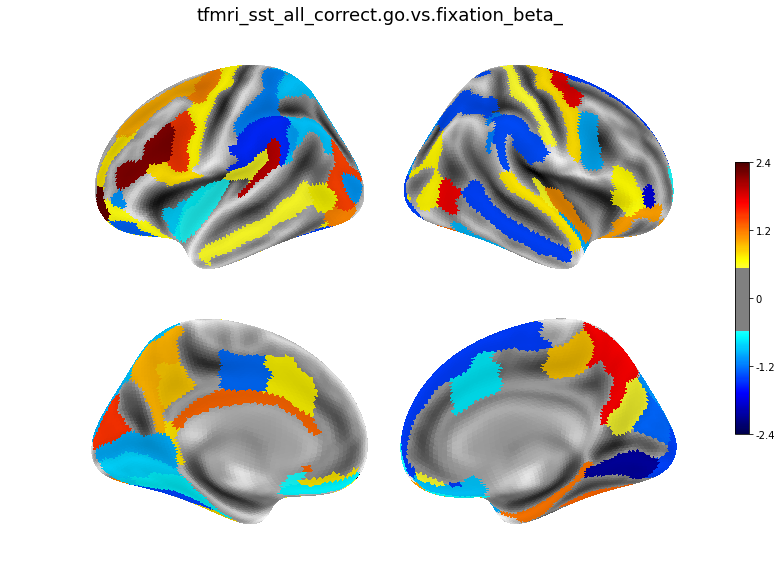

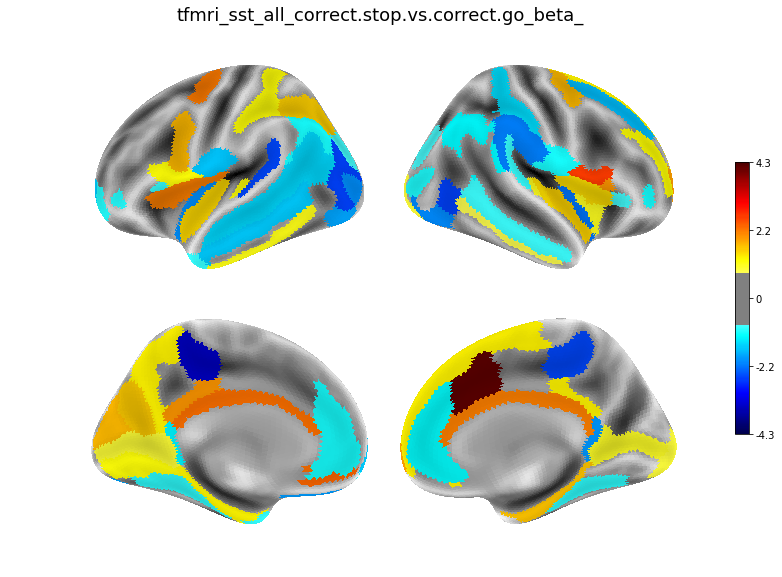

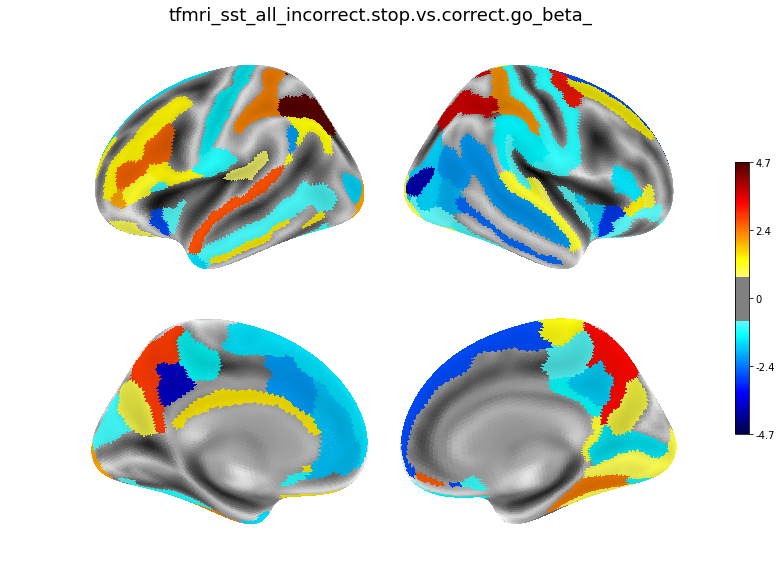

In [46]:
surf_ref = SurfRef(space='fsaverage5', parc='destr')

# Get beta weights seperate by contrast and hemisphere
betas = []
for c_key in contrasts:
    
    b = surf_ref.get_hemis_plot_vals(fis_df,
                                     lh_key='.lh',
                                     rh_key='.rh',
                                     i_keys=['.destrieux', c_key])
    betas.append(b)

# Plot each
for i in range(len(betas)):
    plot(betas[i], title = contrasts[i])

/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


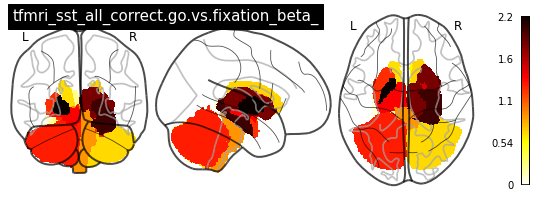

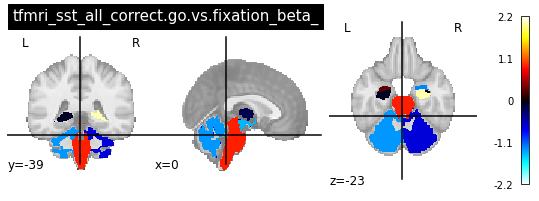

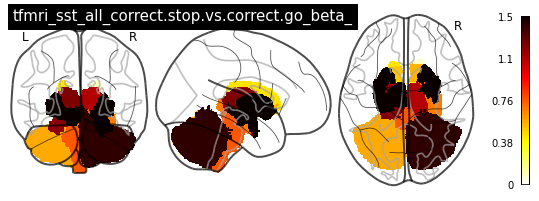

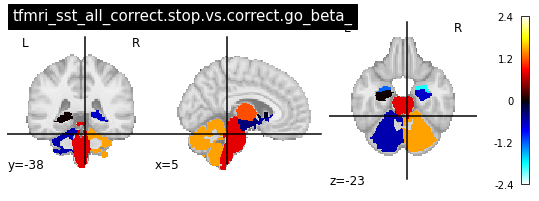

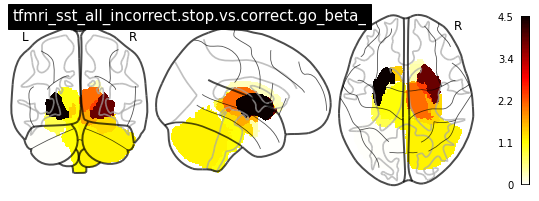

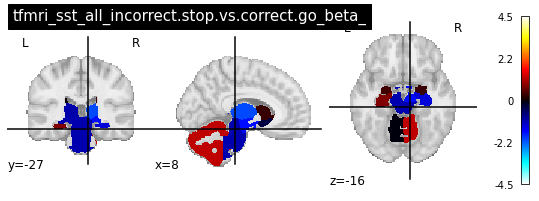

In [50]:
vol_ref = VolRef(parc='aseg')

vols = []
for c_key in contrasts:
    vols.append(vol_ref.get_plot_vals(fis_df, i_keys=['_subcort.aseg', c_key], d_keys=[]))

for i in range(len(contrasts)):
    plot_glass_brain(vols[i], colorbar=True, title=contrasts[i])
    plot_stat_map(vols[i], title=contrasts[i])